In [1]:
import ee, geemap, pickle, requests
import tensorflow as tf
import numpy as np
import geopandas as gpd
from io import BytesIO
from shapely.geometry import mapping
from data_loader import preprocess_new_data, TFDatasetBuilder

In [2]:
ee.Initialize()

In [3]:
model_path = 'models/siamese_fusion_anymarket_2/20250211'
model_name = model_path.split('/')[-2]
model = tf.keras.models.load_model(f'{model_path}/{model_name}.keras')
with open(f'{model_path}/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
with open(f'{model_path}/args.pkl', 'rb') as file:
    args = pickle.load(file)

In [ ]:
def cnn_predictions_country(candidate_locs_folder, model_path):

    # Load model, scaler, and metadata from the model folder
    model_name = model_path.split('/')[-2]
    model_date = model_path.split('/')[-1]
    model = tf.keras.models.load_model(f'{model_path}/{model_name}.keras')
    with open('models/siamese_fusion_anymarket_2/20250213/scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    with open('models/siamese_fusion_anymarket_2/20250213/args.pkl', 'rb') as file:
        args = pickle.load(file)
    predictions_folder = f'{candidate_locs_folder}/S2/cnn_predictions'

    # If predictions folder does not exist, create it
    if not ee.data.getInfo(predictions_folder):
        print('Creating folder:', predictions_folder)
        ee.data.createFolder(predictions_folder)

    # If model folder does not exist, create it
    if not ee.data.getInfo(f'{predictions_folder}/{model_name}'):
        print('Creating folder:', f'{predictions_folder}/{model_name}')
        ee.data.createFolder(f'{predictions_folder}/{model_name}')

    # If model subfolder does not exist, create it
    if not ee.data.getInfo(f'{predictions_folder}/{model_name}/{model_date}'):
        print('Creating folder:', f'{predictions_folder}/{model_name}/{model_date}')
        ee.data.createFolder(f'{predictions_folder}/{model_name}/{model_date}')

    # Get list of diffImgs for this country
    asset_list = ee.data.listAssets(f'{candidate_locs_folder}/S2/diffImgs/')
    diffImg_list = [asset['id'] for asset in asset_list['assets'] if 'norm' not in asset['id']]

    # For each diffImg, make predictions and export to GEE
    for diffImg_id in diffImg_list:
        
        diffImg_name = diffImg_id.split('/')[-1]

        try:


            # If predictions do not exist already, make them
            if not ee.data.getInfo(f'{predictions_folder}/{model_name}/{model_date}' + f'/predictions_{diffImg_name}'):
                
                print('Processing:', diffImg_name)
                diffImg = ee.Image(diffImg_id)
                predictions_ee = predictions_from_diffImg(diffImg, model, scaler, args)

                task = ee.batch.Export.table.toAsset(
                    collection=predictions_ee,
                    description=f'predictions_{diffImg_name}_{model_name}',
                    assetId=f'{predictions_folder}/{model_name}/{model_date}' + f'/predictions_{diffImg_name}',
                )
                task.start()

        except Exception as e:
            print(f'Error with {diffImg_name}')
            print(e)
        

def predictions_from_diffImg(diffImg, model, scaler, args):

    tile_size = 128 
    pixel_size = 3
    tile_length = pixel_size * tile_size
    image_geo = diffImg.geometry()

    # Create an offset grid covering the country
    grid = image_geo.coveringGrid(proj=ee.Projection('EPSG:4326').atScale(tile_length))
    offset_grid = image_geo.buffer(tile_size*pixel_size*0.5) \
        .coveringGrid(proj=ee.Projection('EPSG:4326') \
        .translate(tile_length, tile_length) \
        .atScale(tile_length))
    total_grid = grid.merge(offset_grid)

    # Create a mask of where the image exceeds 2
    high_pixels = diffImg.select('max_all').gt(2).selfMask()

    high_pixels_geo = high_pixels.reduceToVectors(
        scale = 3,
        geometry = image_geo,
        maxPixels = 1e12,
        reducer = ee.Reducer.countEvery()
    ).geometry()

    # Filter the grid to only include the high pixels
    high_pixels_grid = total_grid.filterBounds(high_pixels_geo)

    # Convert high_pixels_grid to GeoJSON
    high_pixels_grid_geojson = high_pixels_grid.getInfo()

    # Convert GeoJSON to GeoPandas DataFrame
    gdf = gpd.GeoDataFrame.from_features(high_pixels_grid_geojson['features'])

    predictions_gdf = predict_gdf_batch(gdf, diffImg, model, scaler, args)

    predictions_ee = gdf_to_ee_feature_collection(predictions_gdf)
    
    return predictions_ee


def convert_row_to_ee_geometry(gdf, row_number):
    # Get the geometry of the specified row
    row_geometry = gdf.iloc[row_number].geometry

    # Convert the geometry to GeoJSON format
    row_geojson = mapping(row_geometry)

    # Create an Earth Engine geometry object
    row_ee_geometry = ee.Geometry(row_geojson)
    
    return row_ee_geometry


def get_image_data(image, geometry, scale=3):
    # Clip the image to the specified geometry
    clipped_image = image.clip(geometry)
    
    # Get the image data as a numpy array
    url = clipped_image.getDownloadURL({
        'scale': scale, 
        'format': 'NPY',
        'bands': [
            {'id':'weekday_0', 'scale':3},
            {'id':'weekday_1', 'scale':3},
            {'id':'weekday_2', 'scale':3},
            {'id':'weekday_3', 'scale':3},
            {'id':'weekday_4', 'scale':3},
            {'id':'weekday_5', 'scale':3},
            {'id':'weekday_6', 'scale':3}
            ]
        })

    response = requests.get(url)
    data = np.load(BytesIO(response.content))
    
    # Reshape the data to have the shape (7, 129, 129)
    new_data = data[['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']]
    new_data = new_data.view((float, len(new_data.dtype.names))).reshape(7, data.shape[0], data.shape[1])
    
    # Check if the data shape is at least (_, 128, 128)
    if new_data.shape[1] < 128 or new_data.shape[2] < 128:
        # Calculate the padding sizes
        pad_width = ((0, 0), (0, max(0, 128 - new_data.shape[1])), (0, max(0, 128 - new_data.shape[2])))
        # Pad the data with 0 values
        new_data = np.pad(new_data, pad_width, mode='constant', constant_values=0)

    return new_data


def predict_image_data(data, model, scaler, args):

    if data.shape[1] < 128 or data.shape[2] < 128:
        raise ValueError('Data must have a shape of at least (7, 128, 128)')

    # Preprocess the data
    processed_data = preprocess_new_data(data, scaler=scaler, do_clipping=args.do_clipping, lower_clip=args.lower_clip, upper_clip=args.upper_clip)
    
    # Predict the data
    prediction = model.predict(np.expand_dims(processed_data, axis=0))
    
    return prediction[0][0]


def predict_gdf_batch(gdf, image, model, scaler, args):
    processed_data_list = []

    for i in range(len(gdf)):
        geometry = convert_row_to_ee_geometry(gdf, i)
        image_data = get_image_data(image, geometry)
        processed_data = preprocess_new_data(image_data, scaler=scaler, do_clipping=args.do_clipping, lower_clip=args.lower_clip, upper_clip=args.upper_clip)
        processed_data_list.append(processed_data)

    if processed_data_list:
        # Stack all image data into a single numpy array
        batch_data = np.stack(processed_data_list)

        # Predict the data
        predictions = model.predict(batch_data)
        
        # Add predictions to the GeoDataFrame
        gdf['prediction'] = predictions

    return gdf


def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = ee.Geometry(mapping(row['geometry']))
        feature = ee.Feature(geom, row.drop('geometry').to_dict())
        features.append(feature)
    return ee.FeatureCollection(features)

In [6]:
country_name = 'Mali'
candidate_locs_folder = f'projects/{country_name.lower()}-candidate-locs/assets'

cnn_predictions_country(candidate_locs_folder, model_path)

Processing: cell_126
Processing: cell_180
Processing: cell_182
Processing: cell_192
Processing: cell_210
Processing: cell_211
Processing: cell_212
Processing: cell_214
Processing: cell_219
Processing: cell_220
Processing: cell_226
Processing: cell_228
Processing: cell_231
Processing: cell_247
Processing: cell_250
Processing: cell_258
Processing: cell_259
Processing: cell_264
Processing: cell_266
Processing: cell_267
Processing: cell_27
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
Processing: cell_270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing: cell_271
Processing: cell_273
Processing: cell_274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing: cell_28
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Processing: cell_283
Processing: cell_284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing: cell_285
Processing: cell_286
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing: cell_287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Processing: cell_288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing: cell_289
3/3

KeyboardInterrupt: 

In [3]:
tile_size = 128 
pixel_size = 3
tile_length = pixel_size * tile_size
diffImg = ee.Image('projects/mali-candidate-locs/assets/S2/diffImgs/cell_159')
image_geo = diffImg.geometry()

# Create an offset grid covering the country
grid = image_geo.coveringGrid(proj=ee.Projection('EPSG:4326').atScale(tile_length))
offset_grid = image_geo.buffer(tile_size*pixel_size*0.5) \
    .coveringGrid(proj=ee.Projection('EPSG:4326') \
    .translate(tile_length, tile_length) \
    .atScale(tile_length))
total_grid = grid.merge(offset_grid)

# Create a mask of where the image exceeds 2
high_pixels = diffImg.select('max_all').gt(2).selfMask()

high_pixels_geo = high_pixels.reduceToVectors(
    scale = 3,
    geometry = image_geo,
    maxPixels = 1e12,
    reducer = ee.Reducer.countEvery()
).geometry()

# Filter the grid to only include the high pixels
high_pixels_grid = total_grid.filterBounds(high_pixels_geo)

# Map the grid
m = geemap.Map()
m.addLayer(diffImg, {}, 'diffImg')
m.addLayer(high_pixels_grid, {}, 'high_pixels_grid')
m.addLayer(high_pixels, {}, 'high_pixels')
m.addLayer(high_pixels_geo, {}, 'high_pixels_geo')
m.centerObject(diffImg)
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
high_pixels_grid.size().getInfo()

48

In [5]:


# Convert high_pixels_grid to GeoJSON
high_pixels_grid_geojson = high_pixels_grid.getInfo()

# Convert GeoJSON to GeoPandas DataFrame
gdf = gpd.GeoDataFrame.from_features(high_pixels_grid_geojson['features'])

# Print the GeoPandas DataFrame
print(gdf)

                                             geometry
0   POLYGON ((-4.54993 14.41904, -4.54648 14.41904...
1   POLYGON ((-4.87764 14.42249, -4.87419 14.42249...
2   POLYGON ((-4.87764 14.42594, -4.87419 14.42594...
3   POLYGON ((-4.87419 14.42939, -4.87074 14.42939...
4   POLYGON ((-4.92938 14.45008, -4.92593 14.45008...
5   POLYGON ((-4.92593 14.45008, -4.92248 14.45008...
6   POLYGON ((-4.92248 14.45008, -4.91903 14.45008...
7   POLYGON ((-4.91903 14.45008, -4.91558 14.45008...
8   POLYGON ((-4.91903 14.45353, -4.91558 14.45353...
9   POLYGON ((-4.82934 14.45353, -4.82589 14.45353...
10  POLYGON ((-4.82244 14.46043, -4.81899 14.46043...
11  POLYGON ((-4.82244 14.46388, -4.81899 14.46388...
12  POLYGON ((-4.90868 14.49493, -4.90523 14.49493...
13  POLYGON ((-4.88798 14.52942, -4.88454 14.52942...
14  POLYGON ((-4.85349 14.55702, -4.85004 14.55702...
15  POLYGON ((-4.7776 14.60876, -4.77415 14.60876,...
16  POLYGON ((-4.77415 14.60876, -4.7707 14.60876,...
17  POLYGON ((-4.74655 14.64

In [8]:



# Example usage
first_row_ee_geometry = convert_row_to_ee_geometry(gdf, 0)

NameError: name 'convert_row_to_ee_geometry' is not defined

In [6]:
import requests
from io import BytesIO



data = get_image_data(diffImg, first_row_ee_geometry)
print(data.shape)

NameError: name 'get_image_data' is not defined

In [7]:
model1 = tf.keras.models.load_model('models/siamese_fusion_anymarket_2/20250211/siamese_fusion_anymarket_2.keras')
model2 = tf.keras.models.load_model('models/siamese_fusion_anymarket_2/20250213/siamese_fusion_anymarket_2.keras')

# Load the model
model = model2

# Min max scaler, min = 0, max = 40
class CustomMinMaxScaler:
    def __init__(self, min_val=0, max_val=40):
        self.min_val = min_val
        self.max_val = max_val

    def transform(self, X):
        return (X - self.min_val) / (self.max_val - self.min_val)

scaler = CustomMinMaxScaler()

def predict_image_data(data, model, scaler):

    if data.shape[1] < 128 or data.shape[2] < 128:
        raise ValueError('Data must have a shape of at least (7, 128, 128)')

    # Preprocess the data
    processed_data = preprocess_new_data(data, scaler=scaler, do_clipping=True, lower_clip=0, upper_clip=40)

    # Plot the value distribution of processed_data
    # plt.figure(figsize=(10, 6))
    # plt.hist(processed_data.flatten(), bins=50, color='blue', alpha=0.7)
    # plt.title('Value Distribution of Processed Data')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.grid(True)
    # plt.show()
    
    # Predict the data
    prediction = model.predict(np.expand_dims(processed_data, axis=0))
    
    return prediction[0][0]

geometry = convert_row_to_ee_geometry(gdf, 0)
image_data = get_image_data(diffImg, geometry)
predict_image_data(image_data, model, scaler)

NameError: name 'convert_row_to_ee_geometry' is not defined

In [44]:
def predict_gdf_batch(gdf, image, model, scaler):
    processed_data_list = []

    for i in range(len(gdf)):
        geometry = convert_row_to_ee_geometry(gdf, i)
        image_data = get_image_data(image, geometry)
        processed_data = preprocess_new_data(image_data, scaler=scaler, do_clipping=True, lower_clip=0, upper_clip=40)
        processed_data_list.append(processed_data)

    if processed_data_list:
        # Stack all image data into a single numpy array
        batch_data = np.stack(processed_data_list)

        # Predict the data
        predictions = model.predict(batch_data)
        
        # Add predictions to the GeoDataFrame
        gdf['predictions'] = predictions

    return gdf

predictions = predict_gdf_batch(gdf, diffImg, model, scaler)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 


In [46]:
def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = ee.Geometry(mapping(row['geometry']))
        feature = ee.Feature(geom, row.drop('geometry').to_dict())
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the GeoPandas DataFrame to an Earth Engine Feature Collection
predictions_ee = gdf_to_ee_feature_collection(predictions)

In [47]:
candidate_locs_existing = ee.FeatureCollection(f'projects/{country_name.lower()}-candidate-locs/assets/S2/locs/cell_159_locs_v20240812')

In [48]:
m = geemap.Map()
empty = ee.Image().byte()
outline = empty.paint(featureCollection=predictions_ee, color='predictions')
m.addLayer(diffImg.select('max_all'), {'max': 10}, 'diffImg')
m.addLayer(predictions_ee.filter(ee.Filter.gt('predictions', 0.2)), {'color': 'cyan'},'high_predictions')
m.addLayer(outline, {'palette': ['black', 'orange']}, 'predictions', False)
m.addLayer(candidate_locs_existing, {'color': 'red'}, 'candidate_locs_existing')
m.centerObject(diffImg)
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Get the centroid of any prediction > 0.2
centroids = predictions_ee.filter(ee.Filter.gt('predictions', 0.2)).map(lambda feature: feature.centroid())
candidate_locs_initial = centroids.map(lambda feature: feature.buffer(250))

def determine_overlapping(feature):
    num_ovelapping = candidate_locs_initial.filterBounds(feature.geometry()).size()
    return feature.set('num_overlapping', num_ovelapping)

candidate_locs_overlapping = candidate_locs_initial.map(determine_overlapping).filter(ee.Filter.gt('num_overlapping', 1))

In [33]:
m = geemap.Map()
m.addLayer(diffImg.select('max_all'), {'max': 10}, 'diffImg')
m.addLayer(outline, {'palette': ['black', 'orange']}, 'predictions')
m.addLayer(candidate_locs, {}, 'candidate_locs')
m.centerObject(diffImg)
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

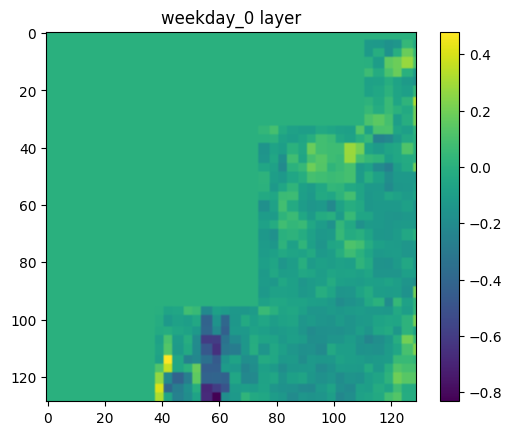

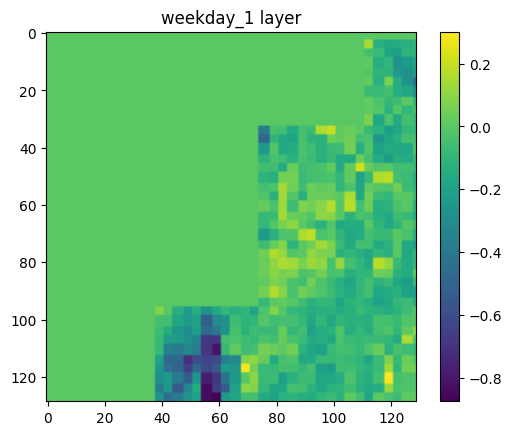

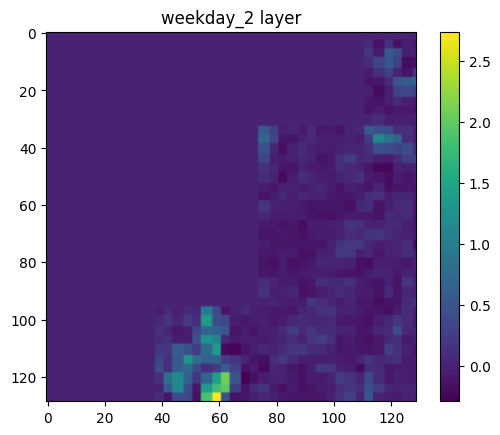

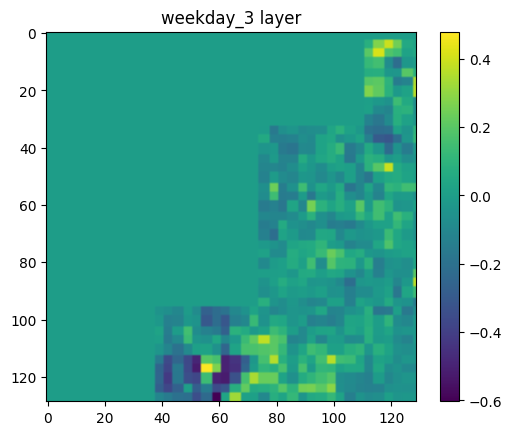

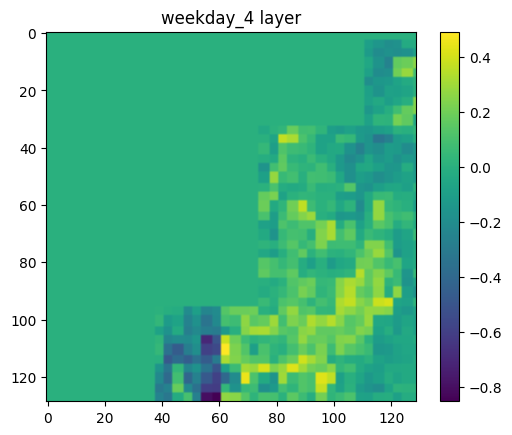

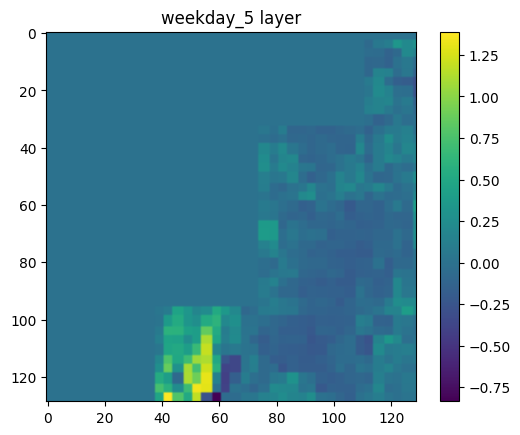

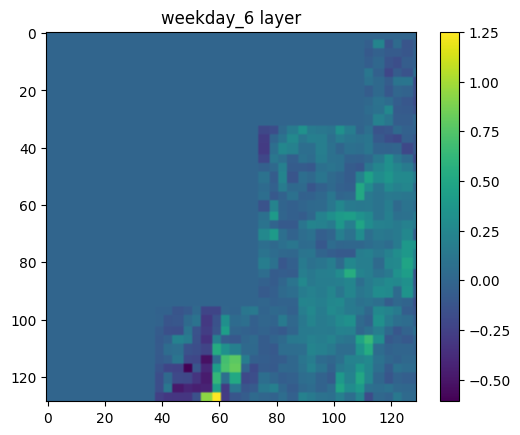

In [ ]:
# visualize the data for each weekday

import matplotlib.pyplot as plt

band_names = diffImg.bandNames().getInfo()

# Visualize each weekday layer
for band in band_names[:-1]:  # Exclude 'max_all'
    plt.figure()
    plt.imshow(data[band], cmap='viridis')
    plt.title(f'{band} layer')
    plt.colorbar()
    plt.show()

In [27]:
# Ensure new_data is defined
new_data = data[['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']]

new_data = new_data.view((float, len(new_data.dtype.names))).reshape(7, 129, 129)

In [35]:
# Map to make sure the prediction is correct
m = geemap.Map()
m.addLayer(diffImg.select('max_all'), {'max':15}, 'diffImg')
m.addLayer(grid_cell, {}, 'grid_cell')
m.centerObject(grid_cell)
m


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [97]:
from data_loader import TFDatasetBuilder


builder = TFDatasetBuilder(
        csv_path="./data/training_data_S2/image_metadata.csv",
        scaling='minmax',
        do_augmentation = True,
        do_clipping = True,
        lower_clip = 0,
        upper_clip = 40
    )

train_ds, val_ds, test_ds = builder.build_datasets(
        train_split=0.70, val_split=0.15,
        sample_size=100,
        batch_size=16
    )

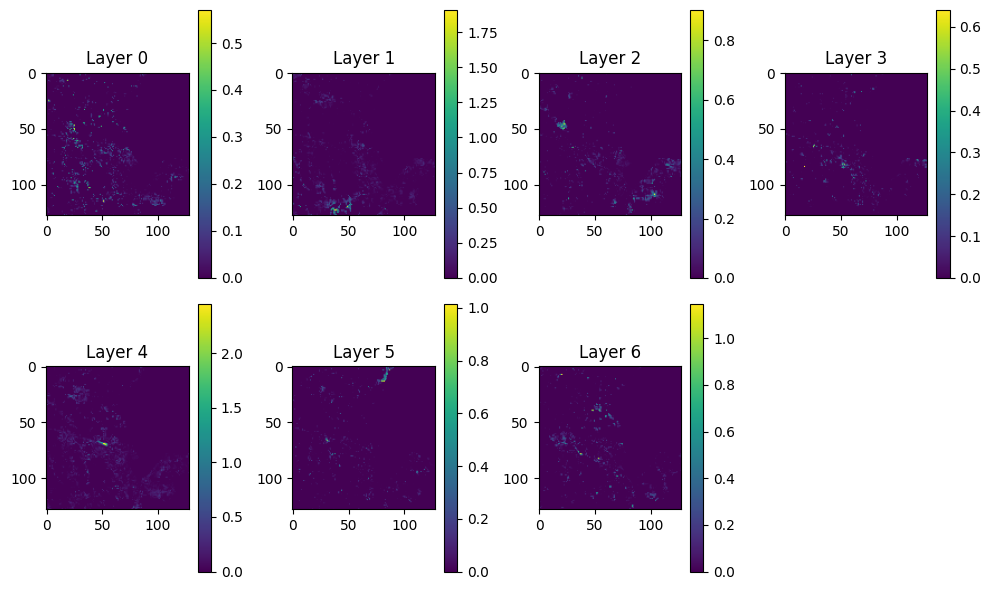

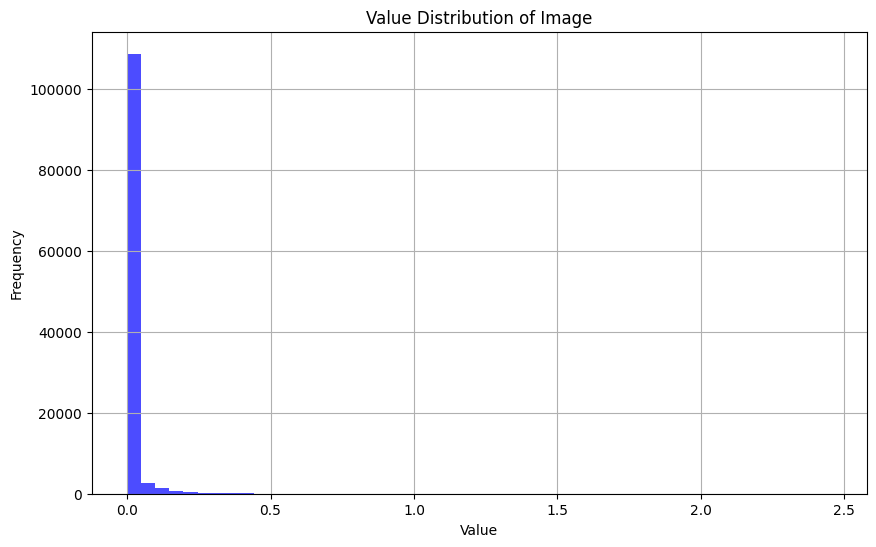

True Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: 0.8746103644371033


In [98]:
import matplotlib.pyplot as plt

def visualize_image_from_dataset(dataset, index=0):
    # Get a batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        image = images[index].numpy()
        true_label = labels[index].numpy()
        break
    
    # Plot the image
    plt.figure(figsize=(10, 6))
    for i in range(image.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(image[i, :, :, 0], cmap='viridis')
        plt.title(f'Layer {i}')
        plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # Plot the histogram of the image values
    plt.figure(figsize=(10, 6))
    plt.hist(image.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Value Distribution of Image')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Show the true label
    print(f'True Label: {true_label}')
    
    # Make a prediction
    prediction = model.predict(np.expand_dims(image, axis=0))
    print(f'Prediction: {prediction[0][0]}')

# Example usage
visualize_image_from_dataset(train_ds, index=5)

In [ ]:
model1 = tf.keras.models.load_model('models/siamese_fusion_anymarket_2/20250211/siamese_fusion_anymarket_2.keras')
model2 = tf.keras.models.load_model('models/siamese_fusion_anymarket_2/20250213/siamese_fusion_anymarket_2.keras')